In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('figures.mplstyle')
import vegas
from functools import partial

from xsec import *
from global_variables import *
from flux import *

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

Erange = np.logspace(2,5,100)

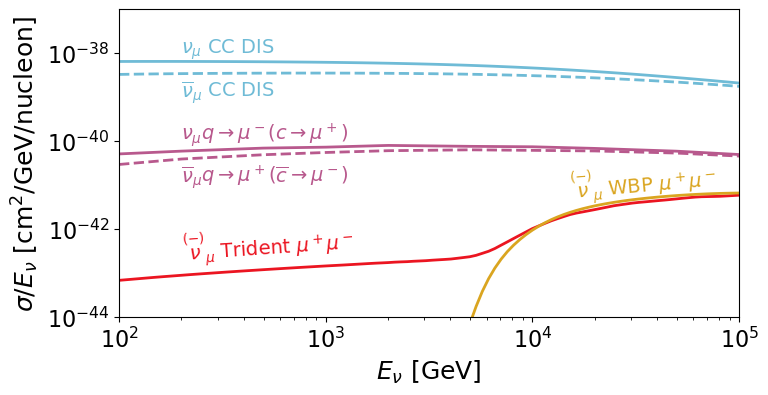

In [9]:
xsec_names = {xsec:r"$\nu_\mu$ CC DIS",
              xsec_charm_dimuon:r"$\nu_\mu q \to \mu^- (c \to \mu ^+)$",
              xsec_trident_dimuon:r"${\nu}_\mu$ Trident $\mu^+ \mu^-$",
              xsec_WBP_dimuon:r"${\nu}_\mu$ WBP $\mu^+ \mu^-$"}
# CSMS results
color = color_list["IC"]
plt.plot(Erange,xsec(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton,ls="-",color=color)
plt.plot(Erange,xsecbar(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton,ls="--",color=color)
#plt.plot(Erange,xsec_NC(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton)
#plt.plot(Erange,xsecbar_NC(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton)
plt.text(200,1e-38,r"$\nu_\mu$ CC DIS",color=color,fontsize=14)
plt.text(200,1e-39,r"$\overline{\nu}_\mu$ CC DIS",color=color,fontsize=14)

# charm dimuons
color = color_list["KM3"]
plt.plot(Erange,xsec_charm_dimuon(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton,ls="-",color=color)
plt.plot(Erange,xsecbar_charm_dimuon(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton,ls="--",color=color)
plt.text(200,1.1e-40,r"$\nu_\mu q \to \mu^- (c \to \mu ^+)$",color=color,fontsize=14)
plt.text(200,1.2e-41,r"$\overline{\nu}_\mu q \to \mu^+ (\overline{c} \to \mu ^-)$",color=color,fontsize=14)

# trident
color = color_list["PONE"]
plt.plot(Erange,xsec_trident_dimuon(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton,ls="-",color=color)
#plt.plot(Erange,xsecbar_trident_dimuon(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton,ls="--",color=color)
plt.text(200,2e-43,r"$\overset{(-)}{\nu}_\mu$ Trident $\mu^+ \mu^-$",color=color,fontsize=14,rotation=4)

# WBP
color = "goldenrod"
plt.plot(Erange,xsec_WBP_dimuon(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton,ls="-",color=color)
#plt.plot(Erange,xsecbar_WBP_dimuon(Erange)/Erange/cm2_per_nucleon__to__m2_per_ton,ls="-.",color=color)
plt.text(1.5e4,5e-42,r"$\overset{(-)}{\nu}_\mu$ WBP $\mu^+ \mu^-$",color=color,fontsize=14,rotation=5)


plt.loglog()
plt.ylabel(r"$\sigma/E_\nu~[{\rm cm}^2/{\rm GeV}/{\rm nucleon}]$")
plt.xlabel(r"$E_\nu~[{\rm GeV}]$")
plt.xlim(Erange[0],Erange[-1])
plt.ylim(1e-44,1e-37)
plt.savefig("figures/xsec.pdf",dpi=100,bbox_inches='tight')
plt.show()

# Rates

In [3]:
# Rate of neutrino interactions / dR / dE
# Units: (Number of Interactions) / m / GeV
def rate(flux, xsec, Enu, R, P, baseline):
    costh = np.cos(R/baseline)
    ret = flux(Emuon, P, Enu, costh, baseline)*xsec(Enu)*MASS*(4*np.pi*R*np.sqrt(RADIUS**2 - R**2)/VOLUME)
    if not isinstance(ret, float):
        ret[R > RADIUS] = 0
    elif R > RADIUS:
        return 0
    return ret

def integrand_dump(x, baseline, xsec):
    Enu, R = x  # x will be a 2D vector [Enu, R]
    return rate(numu_flux_dump, xsec, Enu, R, P, baseline)

def integrand_accelerator(x, baseline, xsec):
    Enu, R = x  # x will be a 2D vector [Enu, R]
    return rate(numu_flux_accelerator, xsec, Enu, R, P, baseline)

# Perform the integration over specified ranges
def perform_integration(experiment,xsec):
    # Define the ranges for Enu and R
    Enu_min, Enu_max = Emuon/10, Emuon  # Replace with actual range
    R_min, R_max = 0.0, RADIUS  # Ensure R is within the allowed radius

    if experiment == "PONE":
        integrand = integrand_accelerator
    else:
        integrand = integrand_dump
    
    # Set up the integrator
    integ = vegas.Integrator([[Enu_min, Enu_max], [R_min, R_max]])

    integrand_partial = partial(integrand, baseline=baseline_list[experiment], xsec=xsec)
    
    # Perform the integration
    result = integ(integrand_partial, nitn=20, neval=1000)
    #print(result.summary())
    return result.val

In [4]:

print("Process",end="")
for exp in experiment_list:
    print(" & %s"%experiment_names[exp],end="")
print(" \\\\")
for _xsec in [xsec,xsec_charm_dimuon,xsec_trident_dimuon,xsec_WBP_dimuon]:
    print(xsec_names[_xsec],end="")
    for exp in experiment_list:
        print(" & $%s$"%latex_float(perform_integration(exp,_xsec)),end="")
    print(" \\\\")

Process & KM3NeT & IceCube & P-ONE \\
$\nu_\mu$ CC DIS & $1.7 \times 10^{8}$ & $1.6 \times 10^{8}$ & $1.3 \times 10^{11}$ \\
$\nu_\mu q \to \mu^- (c \to \mu ^+)$ & $2.2 \times 10^{6}$ & $2.1 \times 10^{6}$ & $1.8 \times 10^{9}$ \\
${\nu}_\mu$ Trident $\mu^+ \mu^-$ & $5.2 \times 10^{3}$ & $5 \times 10^{3}$ & $4.2 \times 10^{6}$ \\
${\nu}_\mu$ WBP $\mu^+ \mu^-$ & $3.6$ & $3.6$ & $2.8 \times 10^{3}$ \\
